<a href="https://colab.research.google.com/github/Malekkamoua/PFE/blob/main/5_Forecasting%20%7C%20Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
from google.colab import drive

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [12]:
df = pd.read_csv('/content/gdrive/MyDrive/Datascience/Datasets/final_dataset_fs_db.csv', parse_dates=['dates'],  index_col='dates',infer_datetime_format=True)
df.drop(['Unnamed: 0', 'Purity'], axis=1, inplace=True)

In [13]:
from sklearn.preprocessing import MinMaxScaler

# Normalization
values = df[['% Silica Concentrate']].values

# Normalization
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(values)

In [14]:
def create_data(series, prev_instances = 4):
 
    X_train_1 = pd.DataFrame(series).astype('float64')
    X_train_temp = X_train_1.shift(1)
    y_label = X_train_1.shift(-1)
    
    data = pd.concat([X_train_temp, X_train_1, y_label], axis=1)
    
    for r in range(prev_instances-2):
      X_train_temp = X_train_temp.shift(1)
      data = pd.concat([X_train_temp, data], axis=1)
    data.dropna(inplace = True)
    data.reset_index(drop = True, inplace = True)
    # print(data.head(10))
    X = data.iloc[:, 0:-1].values 
    y = data.iloc[:,-1].values 
    
    print('This series takes {} previous instances'.format(prev_instances))
    
    data.columns = [*data.columns[:-1], 'y']
    
    return data, X, y

In [15]:
WINDOW_SIZE = 5

time_series = scaled_data;
data, X, y = create_data(time_series, prev_instances = WINDOW_SIZE)

This series takes 5 previous instances


In [16]:
# 70% 15% 15%

X_train, y_train = X[:3935], y[:3935]
X_test, y_test = X[3935:4775], y[3935:4775]
X_val, y_val = X[4775:], y[4775:]
X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_val.shape, y_val.shape

((3935, 5), (3935,), (840, 5), (840,), (841, 5), (841,))

In [17]:
# reshape input to be 3D [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], WINDOW_SIZE,1))
X_test = X_test.reshape((X_test.shape[0], WINDOW_SIZE, 1))
X_val = X_val.reshape((X_val.shape[0], WINDOW_SIZE, 1))
    
X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_val.shape, y_val.shape

((3935, 5, 1), (3935,), (840, 5, 1), (840,), (841, 5, 1), (841,))

In [ ]:
from statsmodels.tsa.stattools import acf

def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  
    mae = np.mean(np.abs(forecast - actual))    
    rmse = np.mean((forecast - actual)**2)**.5  

    return mape, mae, rmse

In [75]:
from keras import backend as K
from keras.layers import Layer, Input, LSTM
from keras.layers import Permute,TimeDistributed,Dense,Reshape,Activation,Lambda,Dropout
import math
import numpy as np


class MultiHeadedAttention():
    '''
    Self-Attention layer of Transformer block described in "Attention is all you need".
    d_model: the output dimensions for embeddings of each token in the sequence.
    heads  : number of heads 
    dim_q  : query vector and key vector dimensions
    dim_v  : value vector dimensions
    dropout_rate : dropout rate before fully connected layer
    '''
    def __init__(self,d_model ,heads,dim_q,dim_v,dropout_rate,name, **kwargs):
        self.heads=heads
        self.dim_q=dim_q
        self.dim_v=dim_q

        self.query_layer   = TimeDistributed(Dense(self.heads*self.dim_q,use_bias = False),name = name+'_QueryLayer')
        self.key_layer     = TimeDistributed(Dense(self.heads*self.dim_q,use_bias = False),name = name+'_KeyLayer')
        self.value_layer   = TimeDistributed(Dense(self.heads*self.dim_v,use_bias = False),name = name+'_ValueLayer') 

        self.dropout_layer = Dropout(dropout_rate)

        self.output_layer  = TimeDistributed(Dense(d_model,use_bias = False),name = name+'_AttentionOutputLayer')

    # moves up the timestep dimention towards the end and heads towards batch_size dimention
    def shift_timestep_ahead(self,vec,last_dim,time_steps,transpose=False):
      vec     = Reshape([-1,self.heads,last_dim])(vec)

      if transpose:
        vec   = Permute([2,3,1])(vec)
        vec   = Lambda(lambda x:K.reshape(x, [-1,  last_dim, time_steps ]))(vec)

      else:
        vec   = Permute([2,1,3])(vec)
        vec   = Lambda(lambda x:K.reshape(x, [-1, time_steps,  last_dim ]))(vec)

      return vec

    # moves down the timestep dimention towards the batch_size dimention
    def shift_timestep_behind(self,vec,last_dim,time_steps):
      vec    = Lambda(lambda x:K.reshape(x, [-1,self.heads, time_steps,  last_dim ]))(vec)
      vec    = Permute([2,1,3])(vec)

      vec    = Lambda(lambda x:K.reshape(x, [-1,time_steps,self.heads*last_dim ]))(vec)

      return vec

    def scaledDotAttention(self):
        '''
        Scaled dot attention : computes the attention score by dot product of query vector and 
        key vector. Sums the value vectors of tokens based on attention weights( after softmax of attention score )
        '''
        attention_score   = Lambda( lambda x: K.batch_dot(x[0],x[1]) / np.sqrt(self.dim_q))([self.query_vec,self.key_vec])
        attention_weights = Activation('softmax')(attention_score)
        attention_vector  = Lambda( lambda x: K.batch_dot(x[0],x[1]))([attention_weights,self.value_vec])

        return attention_vector, attention_weights

    def __call__(self, x):

        a = x
        time_steps = int(a.get_shape()[1])
        self.query_vec = self.query_layer(a)
        self.key_vec   = self.key_layer(a)
        self.value_vec = self.value_layer(a)

        # Reshape
        self.query_vec = self.shift_timestep_ahead(self.query_vec,self.dim_q,time_steps,transpose = False)
        self.key_vec   = self.shift_timestep_ahead(self.key_vec,self.dim_q,time_steps,transpose = True)
        self.value_vec = self.shift_timestep_ahead(self.value_vec,self.dim_v,time_steps,transpose= False)

        # Attention Weights
        self.attention_vec,self.attention_weights = self.scaledDotAttention()

        # print(self.attention_weights,self.attention_vec)
        self.attention_weights = Lambda( lambda x: K.reshape(x,[-1,self.heads,time_steps,time_steps]))(self.attention_weights)
        self.attention_vec     = Lambda( lambda x: K.reshape(x,[-1,time_steps,self.dim_v]))(self.attention_vec)

        #Output Fully Connected Dense
        temp_out               = self.shift_timestep_behind(self.attention_vec,self.dim_v,time_steps)
        temp_out               = self.dropout_layer(temp_out)
        self.out_vec           = self.output_layer(temp_out)

        return [self.out_vec,self.attention_weights]


In [59]:
from keras import backend as K
from keras.layers import Layer
import math
import numpy as np
import tensorflow as tf
from keras.initializers import Ones,Zeros

class LayerNormalization(Layer):
    '''
    Layer normalization of the input with trainable gain_parameter and bias parameter
    Source: https://github.com/Lsdefine/attention-is-all-you-need-keras/blob/master/transformer.py#L14
    '''
    def __init__(self, **kwargs):
        super(LayerNormalization, self).__init__(**kwargs)

    def build(self, input_shape):
        self.epsilon   = 1e-6
        self.gain_para = self.add_weight(name='gain_parameter',
                                          shape=[input_shape[1],1],
                                          initializer = Ones(),trainable=True)
        self.bias_para = self.add_weight(name='bias_parameter',
                                          shape=[input_shape[1],1],
                                          initializer = Zeros(),
                                          trainable = True)

        super(LayerNormalization, self).build(input_shape)  # Be sure to call this at the end

    def call(self, x):

        mean = K.mean(x,axis=-1,keepdims=True)
        std  = K.std(x,axis=-1,keepdims=True)

        normalised_vec = ((x-mean) / (std + self.epsilon)) * self.gain_para + self.bias_para
        return normalised_vec

    def compute_output_shape(self, input_shape):
        # assert isinstance(input_shape, list)
        return input_shape

In [21]:
from keras.layers import TimeDistributed,Dense,Dropout
import keras

class PositionWiseFeedForward():
    '''
        Applies a position wise feed forward dense layer on each token embedding
    '''
    def __init__(self,d_model,inner_dim,dropout_rate,name, **kwargs):

        self.inner_dim     = inner_dim

        self.hidden_layer  = TimeDistributed(Dense(self.inner_dim,activation=keras.activations.relu),name = name+'_PositionWiseFeedForward')
        self.dropout_layer = Dropout(dropout_rate)
        self.out_layer     = TimeDistributed(Dense(d_model),name = name+'_outffn')


    def __call__(self, x):

        self.hidden_vec = self.hidden_layer(x)
        self.hidden_vec = self.dropout_layer(self.hidden_vec)
        self.out_vec    = self.out_layer(self.hidden_vec)

        return self.out_vec

In [22]:
from keras import backend as K
from keras.layers import Layer
from keras.layers import Add
import math

class TransformerEncoder():
    '''
    Main Transformer Encoder block : Encapsulates different layers with a Transformer Encoder block and calls them in order.
    Inputs
    d_model : dimensions of the output and internal layers
    heads   : number of heads
    dim_q   : query and key dimension 
    dim_v   : value dimension
    hidden_units : hidden units for the positionwise feed forward network
    dropout_rate : dropout_rate

    Outputs
    A tuple:Transformer Encoder Representation, attention weights for each head and token
    '''
    def __init__(self, d_model,heads,dim_q,dim_v,hidden_units,dropout_rate,name,activation='relu', **kwargs):
        self.dim_v        = dim_v
        self.dim_q        = dim_q
        self.hidden_units = hidden_units
        self.heads        = heads

        self.attention_layer      = MultiHeadedAttention(d_model = d_model,heads = self.heads,dim_q = self.dim_q,dim_v = self.dim_v,dropout_rate=dropout_rate,name=name)
        self.normalization_layer  = LayerNormalization()
        self.feedforward          = PositionWiseFeedForward(d_model = d_model,inner_dim = self.hidden_units,dropout_rate=dropout_rate,name=name)


    def __call__(self, x):

        attention_vec,attention_weights   = self.attention_layer(x)
        normalized_inp                    = self.normalization_layer(Add()([attention_vec,x]))
        feedforward_out                   = self.feedforward(normalized_inp)

        transformer_out = self.normalization_layer(Add()([feedforward_out,normalized_inp]))

        return [transformer_out,attention_weights]


In [61]:
from keras.layers import Layer
class TransformerPositionalEmbedding(Layer):
    """
    Trainable positional embeddings: to be added to the inputs of Transformer block to learn 
    sequence information carried by the sentences.
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def build(self, input_shape):
        sequence_length, d_model = input_shape[-2:]
        self.position_embeddings = self.add_weight(
            shape=(sequence_length, d_model),
            initializer='uniform',
            name='position_embeddings',
            trainable=True)

        super().build(input_shape)

    def call(self, inputs, **kwargs):
        result = inputs + self.position_embeddings

        return result

In [86]:
from datetime import datetime
from time import time 

import tensorflow as tf
import keras
from keras import layers
from keras.models import Model
from keras.models import load_model
from keras.models import Sequential

from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
from keras.callbacks import Callback

from keras.losses import MeanSquaredError, MeanAbsolutePercentageError
from keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

from keras.models import load_model
from keras.utils.vis_utils import plot_model

class Transformer(object):

    def __init__(self):

        self.look_back = 5
        self.n_features = 1
        self.horizon = 1

        self.checkpoint_dir = "checkpoint"

        self.head_size=128
        self.num_heads=128
        self.num_transformer_blocks=16
        self.mlp_units=[256]
        self.mlp_dropout=0.2
        self.dropout=0.25
        self.hidden_dim = 100  # Number of neurons in each recurrent unit 
        self.positional_ff_dim = 128

    def build(self):

        encoder_inputs = Input(shape=(self.look_back, self.n_features),dtype='float32',name='Encoder_input')
        
        positional_embedding_layer    = TransformerPositionalEmbedding(name='Positional_embedding')
        next_step_input               = positional_embedding_layer(encoder_inputs)
        
        for _ in range(self.num_transformer_blocks):
            next_step_input,attention =TransformerEncoder(self.hidden_dim,
                                                                    self.num_heads,
                                                                    self.hidden_dim,
                                                                    self.hidden_dim,
                                                                    self.positional_ff_dim,
                                                                    dropout_rate= self.dropout,
                                                                    name= 'Transformer')(next_step_input)
           

        x = layers.GlobalAveragePooling1D(data_format="channels_first")(encoder_inputs)
        for dim in self.mlp_units:
            x = layers.Dense(dim, activation="relu")(x)
            x = layers.Dropout(self.mlp_dropout)(x)

        # output layer
        outputs = layers.Dense(self.horizon)(x)

        return keras.Model(encoder_inputs, outputs)

    
    def train(self, X_train, y_train, epochs, batch_size):

        self.model = self.build()
        self.model.compile( loss = MeanSquaredError(), 
                           optimizer = Adam(learning_rate= 0.0001), 
                           metrics=['mae',
                                    MeanSquaredError(),
                                    RootMeanSquaredError(),
                                    MeanAbsolutePercentageError()])

        early_stopping_monitor = EarlyStopping(monitor="loss",
                                               min_delta=0.001,
                                               patience=10,
                                               mode="min",
                                               verbose=1)

        # Save the best model ... with minimal error
        filepath = self.checkpoint_dir+"/Transformer.best"+datetime.now().strftime('%d%m%Y_%H:%M:%S')+".hdf5"
        cp = ModelCheckpoint(filepath,
                                     monitor=MeanAbsolutePercentageError(),
                                     verbose=1,
                                     save_best_only=True,
                                     mode='min')

        callback_history = self.model.fit(X_train, y_train,
                                          epochs=epochs,
                                          batch_size=batch_size,
                                          verbose=1,
                                          callbacks=[
                                                     cp])

In [87]:
## Testing the Transformer 
tr = Transformer()       
tr.train(X_train,y_train, 200, 128)   

Epoch 1/200
31/31 [==============================] - 1s 3ms/step - loss: 0.2699 - mae: 0.4436 - mean_squared_error: 0.2691 - root_mean_squared_error: 0.5195 - mean_absolute_percentage_error: 94.9584
Epoch 2/200
31/31 [==============================] - 0s 3ms/step - loss: 0.1605 - mae: 0.3266 - mean_squared_error: 0.1601 - root_mean_squared_error: 0.4006 - mean_absolute_percentage_error: 64.6268
Epoch 3/200
31/31 [==============================] - 0s 3ms/step - loss: 0.0857 - mae: 0.2278 - mean_squared_error: 0.0854 - root_mean_squared_error: 0.2928 - mean_absolute_percentage_error: 45.2731
Epoch 4/200
31/31 [==============================] - 0s 3ms/step - loss: 0.0469 - mae: 0.1687 - mean_squared_error: 0.0468 - root_mean_squared_error: 0.2165 - mean_absolute_percentage_error: 41.6419
Epoch 5/200
31/31 [==============================] - 0s 3ms/step - loss: 0.0323 - mae: 0.1418 - mean_squared_error: 0.0323 - root_mean_squared_error: 0.1798 - mean_absolute_percentage_error: 44.3134
Epoch

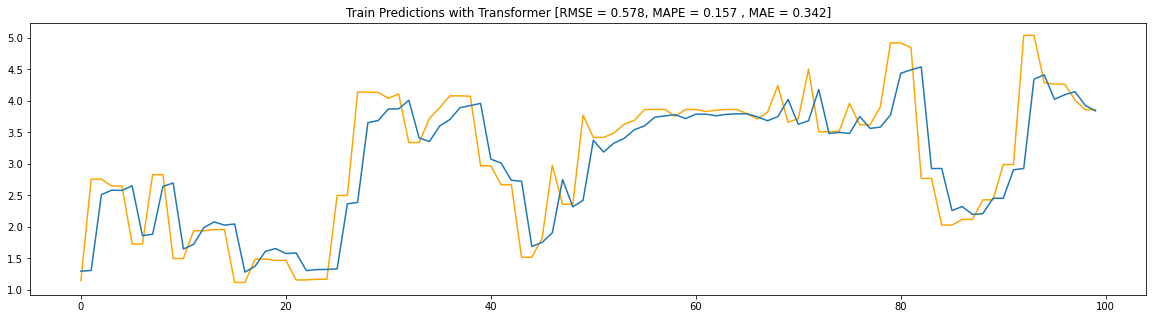

In [88]:
y_pred_train = tr.model.predict(X_train) 
 
y_pred_train = tr.model.predict(np.asarray(X_train).astype('float32'))
Inverse_y_train = y_train.reshape(-1,1)
Inverse_y_train = scaler.inverse_transform(Inverse_y_train)
Inverse_y_pred_train = scaler.inverse_transform(y_pred_train)
 
mape, mae, rmse = forecast_accuracy(Inverse_y_pred_train, Inverse_y_train)

fig, ax = plt.subplots(figsize=(20,5))
plt.plot(Inverse_y_train[0:100], color='orange')
plt.plot(Inverse_y_pred_train[0:100])
plt.title("Train Predictions with Transformer [RMSE = %.3f, MAPE = %.3f , MAE = %.3f]" % (rmse, mape, mae) )
plt.show()

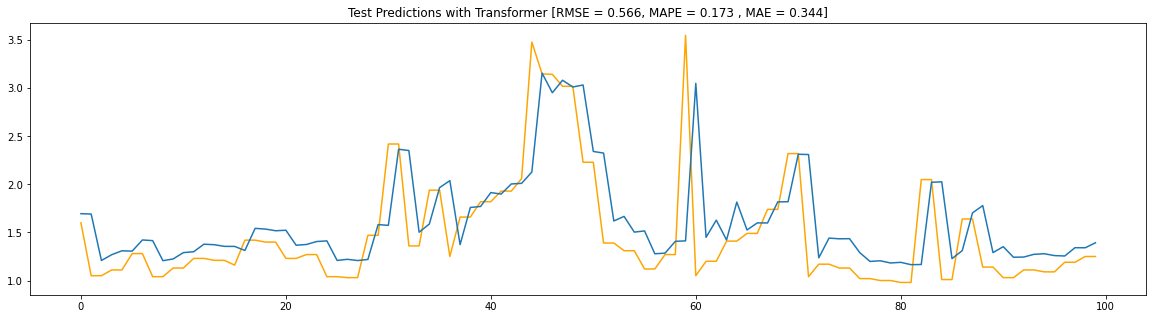

In [89]:
y_pred_test = tr.model.predict(X_test)

y_pred_test = tr.model.predict(np.asarray(X_test).astype('float32'))
Inverse_y_test = y_test.reshape(-1,1)
Inverse_y_test = scaler.inverse_transform(Inverse_y_test)
Inverse_y_pred_test = scaler.inverse_transform(y_pred_test)

mape, mae, rmse = forecast_accuracy(Inverse_y_pred_test, Inverse_y_test)

fig, ax = plt.subplots(figsize=(20,5))
plt.plot(Inverse_y_test[0:100], color='orange')
plt.plot(Inverse_y_pred_test[0:100])
plt.title("Test Predictions with Transformer [RMSE = %.3f, MAPE = %.3f , MAE = %.3f]" % (rmse, mape, mae) )
plt.show() 

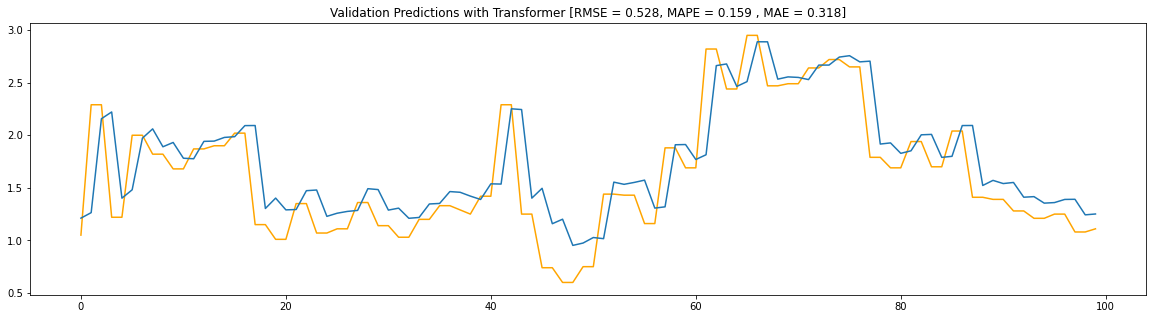

In [90]:
y_pred_val = tr.model.predict(X_val)

y_pred_val = tr.model.predict(np.asarray(X_val).astype('float32'))
Inverse_y_val = y_val.reshape(-1,1)
Inverse_y_val = scaler.inverse_transform(Inverse_y_val)
Inverse_y_pred_val = scaler.inverse_transform(y_pred_val)

mape, mae, rmse = forecast_accuracy(Inverse_y_pred_val, Inverse_y_val)

fig, ax = plt.subplots(figsize=(20,5))
plt.plot(Inverse_y_val[0:100], color='orange')
plt.plot(Inverse_y_pred_val[0:100])
plt.title("Validation Predictions with Transformer [RMSE = %.3f, MAPE = %.3f , MAE = %.3f]" % (rmse, mape, mae) )
plt.show()

## Save model

In [91]:
filepath = '/content/gdrive/MyDrive/Datascience/PFE/transformer_model.h5'
tr.model.save(filepath, save_format="h5")

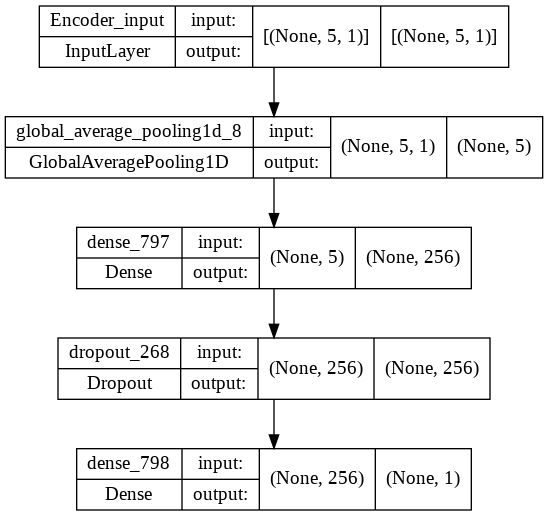

In [92]:
plot_model(tr.model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

## Testing saved model

In [71]:
from keras.models import load_model
from keras.utils.vis_utils import plot_model

best_model = load_model(filepath, compile=False)

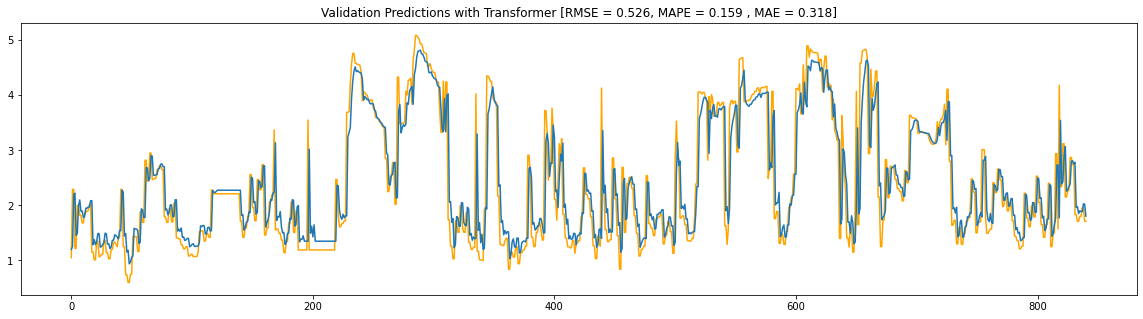

In [72]:
y_pred_val = best_model.predict(np.asarray(X_val).astype('float32'))
Inverse_y_val = y_val.reshape(-1,1)
Inverse_y_val = scaler.inverse_transform(Inverse_y_val)
Inverse_y_pred_val = scaler.inverse_transform(y_pred_val)

mape, mae, rmse = forecast_accuracy(Inverse_y_pred_val, Inverse_y_val)

fig, ax = plt.subplots(figsize=(20,5))
plt.plot(Inverse_y_val, color='orange')
plt.plot(Inverse_y_pred_val)
plt.title("Validation Predictions with Transformer [RMSE = %.3f, MAPE = %.3f , MAE = %.3f]" % (rmse, mape, mae) )
plt.show()

In [73]:
Inverse_y_pred_val[50].tolist()[0]

1.0583100318908691

In [74]:
Inverse_y_val[50].tolist()[0]

0.75